<h1> import libraries

In [ ]:
import matplotlib.pyplot as plt 
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet  import DenseNet169
from tensorflow.keras import Model
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Flatten ,Dropout , Dense  ,Conv2D , MaxPooling2D ,BatchNormalization 
import numpy as np 
import pandas as pd 

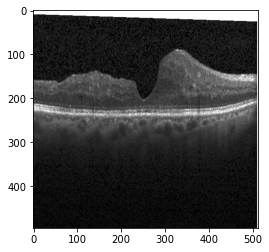

In [1]:
image = plt.imread("../input/kermany2018/OCT2017 /train/DME/DME-1072015-1.jpeg")
plt.imshow(image,cmap='gray')


<h1> Explore data 

In [2]:
TrainPath="../input/kermany2018/OCT2017 /train/"
TestPath="../input/kermany2018/OCT2017 /test/"
ValidationPath="../input/kermany2018/OCT2017 /val/"

print(TrainPath)
print(TestPath)
print(ValidationPath)

../input/kermany2018/OCT2017 /train/
../input/kermany2018/OCT2017 /test/
../input/kermany2018/OCT2017 /val/


the numbers of images in DME class :  11348
(512, 512)


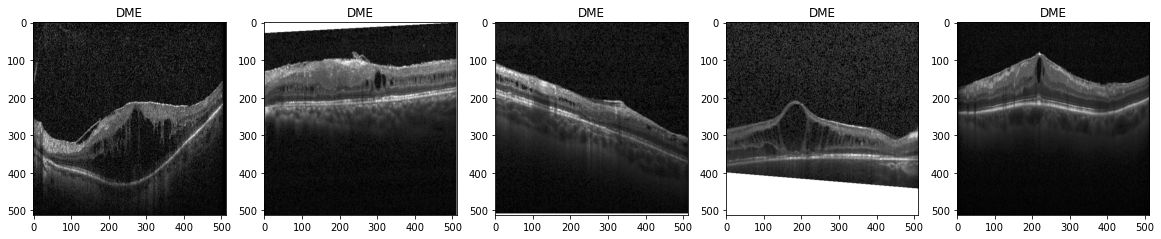

the numbers of images in DRUSEN class :  8616
(496, 768)


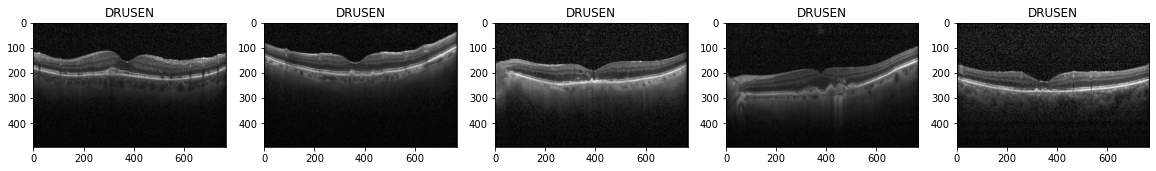

the numbers of images in CNV class :  37205
(496, 768)


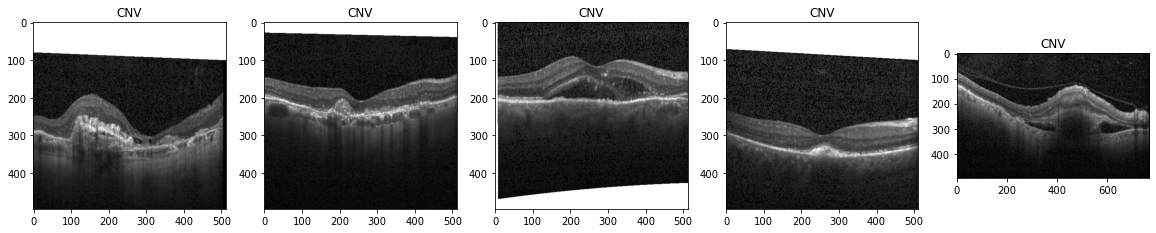

the numbers of images in NORMAL class :  26315
(496, 768)


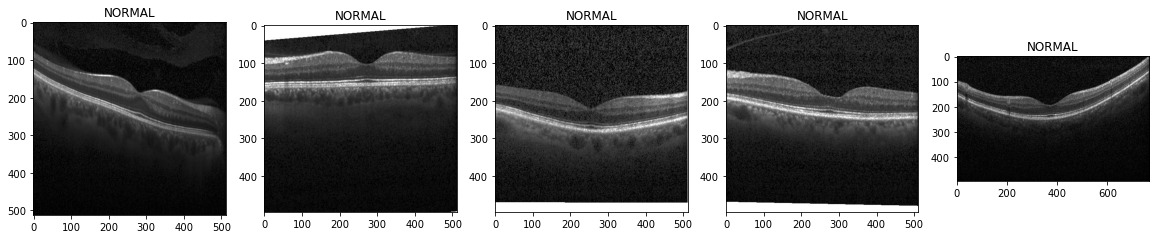

In [3]:
trainClass=os.listdir(TrainPath)
for i in range(len(trainClass)):
    imageInfile=[]
    imageInfile=os.listdir(os.path.join(TrainPath,trainClass[i]))
    print( f"the numbers of images in {trainClass[i]} class : " , len(imageInfile))
    plt.figure(figsize=(20,20))
    for j in range(5):
        
        plt.subplot(1,5,j+1)
        image=plt.imread(os.path.join(os.path.join(TrainPath,trainClass[i]),imageInfile[j]))
        plt.title(trainClass[i])
        plt.imshow(image,cmap='gray')
    print(image.shape)
    plt.show()

<h2>after explore dataset we show these images arenot in the same size and same scale </h2>
    the dataset isnot balance , Unfortunately the dataset imbalance 
    I use the Data Augmentation to read , resize , rescale and balance dataset(but we not do this now) 

<h1>DataAugmentation

In [4]:

imageDelegate=ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    )


In [5]:
ImageSize=224
trainGenerator=imageDelegate.flow_from_directory(
    TrainPath,
    batch_size=50,
    target_size=(ImageSize,ImageSize)  
)

testGenerator =imageDelegate.flow_from_directory(
     TestPath,
     batch_size= 10,
     target_size=(ImageSize, ImageSize)
)

validationGenerator =imageDelegate.flow_from_directory(
     ValidationPath,
     batch_size=4,
     target_size=(ImageSize, ImageSize)
)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [6]:
Labels={0:"BME",1:"CNV",2:"DRUSEN",3:"NORMAL"}
def GetLabel(key):
    return Labels[key]


print(GetLabel(0))
print(GetLabel(1))
print(GetLabel(2))
print(GetLabel(3))

BME
CNV
DRUSEN
NORMAL


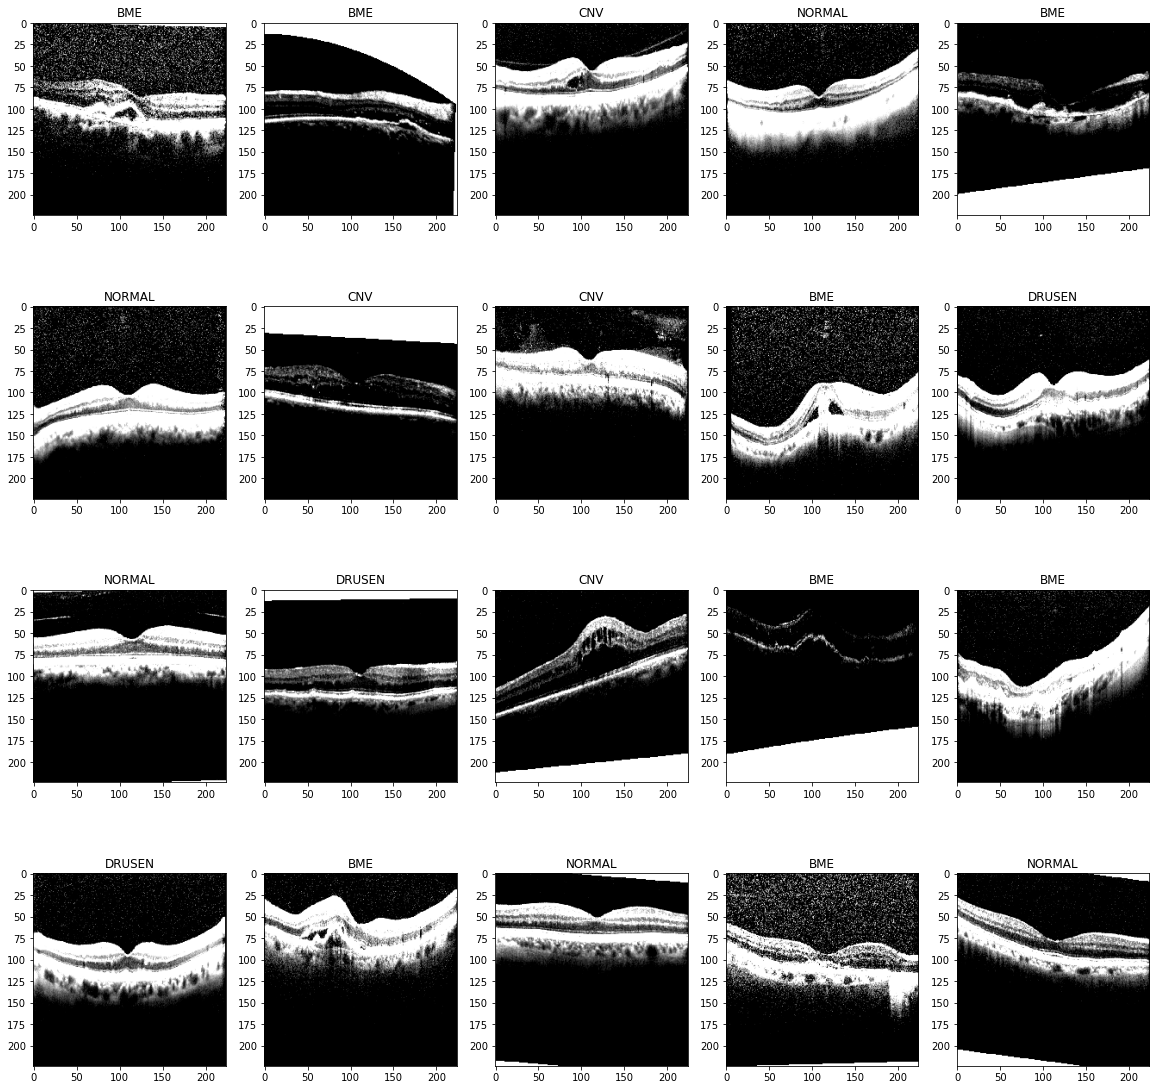

In [7]:
plt.figure(figsize=(20,20))
for i  in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(trainGenerator.__getitem__(0)[0][i])
    plt.title(GetLabel(np.argmax(trainGenerator.__getitem__(0)[1][i])))
    
    


In [ ]:
trainGenerator.__getitem__(0)[0][1].shape

<h1>Build Models

In [8]:
preTrainedModelMobileNet = MobileNet(input_shape =( ImageSize, ImageSize, 3), include_top = False)
for layer in preTrainedModelMobileNet.layers:
    layer.trainable = False  
preTrainedModelMobileNet.summary()
from tensorflow.keras import Model


17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [11]:
#DenseNet169 Model
x=Flatten()(preTrainedModelMobileNet.output)

#Fully Connection Layers
# FC1

x=Dense(512, activation="relu")(x)

# FC2
x=Dense(128, activation="relu")(x)


#output layer
x=Dense(4,activation="sigmoid")(x)


ModelMobileNet=Model(preTrainedModelMobileNet.input,x)
ModelMobileNet.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [12]:

#Optimzation
ModelMobileNet.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])

#Fit model
historyModelMobileNet=ModelMobileNet.fit_generator(trainGenerator,epochs=30,steps_per_epoch=83484/50,validation_data=validationGenerator ,validation_steps=96,verbose=1 )

Epoch 1/30
1670/1669 [==============================] - 555s 332ms/step - loss: 0.2165 - accuracy: 0.8792 - val_loss: 0.1049 - val_accuracy: 0.8750
Epoch 2/30
1670/1669 [==============================] - 378s 227ms/step - loss: 0.1048 - accuracy: 0.9228
Epoch 3/30
1670/1669 [==============================] - 371s 222ms/step - loss: 0.0827 - accuracy: 0.9384
Epoch 4/30
1670/1669 [==============================] - 371s 222ms/step - loss: 0.0663 - accuracy: 0.9509
Epoch 5/30
1670/1669 [==============================] - 370s 222ms/step - loss: 0.0529 - accuracy: 0.9609
Epoch 6/30
1670/1669 [==============================] - 366s 219ms/step - loss: 0.0441 - accuracy: 0.9680
Epoch 7/30
1670/1669 [==============================] - 369s 221ms/step - loss: 0.0370 - accuracy: 0.9728
Epoch 8/30
1670/1669 [==============================] - 369s 221ms/step - loss: 0.0295 - accuracy: 0.9788
Epoch 9/30
1670/1669 [==============================] - 369s 221ms/step - loss: 0.0260 - accuracy: 0.9817
Epoc

In [ ]:
ModelMobileNet.save("ModelMobileNet.h5")

In [14]:
ModelMobileNet.evaluate(testGenerator)

97/97 [==============================] - 5s 54ms/step - loss: 0.0310 - accuracy: 0.9917


[0.031027711927890778, 0.9917355179786682]